### Musical Instrument Classificator - Made by: Juan David Velasquez R.
This Project goes for an Online E-Shop which was required an automated classifier for musical instruments, optimizing the time for the owner to manage their stock and categories within the plataform.

This project employs 3 neural networks EffcientNet B1 - B3, and a CatBoost classifier with the aim to build an ensemble model stacking strategy which combines the predictions of the EfficientNet as base models, and the CatBoost as the Meta Model.

Libraries Import and Data Path is declared

In [123]:
!pip install catboost
from catboost import CatBoostClassifier, Pool
import kagglehub
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB1
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from google.colab.patches import cv2_imshow
from keras.models import load_model
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

nikolasgegenava_music_instruments_path = kagglehub.dataset_download('nikolasgegenava/music-instruments') # Path to dataset.

# The dataset is checked whether it exists and is available to access to.
if nikolasgegenava_music_instruments_path is not None:
  print('The data exists, please proceed.')
else:
  print("Try again, the access to the data was not successful.")

The data exists, please proceed.


Functions to be used throughout in the code

In [69]:
def preprocess_cv(image_np, brightness=10, contrast=2.3):
  """
  Performs the image processing by adjusting the brightness and contrast
  levels, also, applies some image sharpening filters as well as resizing.

  Args:
      image_np: Input image as numpy array.
      brightness: Brightness level (default is 10).
      contrast: Contrast level (default is 2.3).
  """
  # Apply median blur to reduce noise
  img = cv.medianBlur(image_np, 3)

  # Sharpen the image using a custom kernel
  kernel = np.array([[0, -1, 0],
                      [-1, 5, -1],
                      [0, -1, 0]])
  img = cv.filter2D(img, -1, kernel)

  # Adjust contrast and brightness
  final = cv.addWeighted(img, contrast, np.zeros(img.shape, img.dtype), 0, brightness)

  # Resize to 196x196
  return cv.resize(final, (196, 196))

# **************************************************************************************

# This function allows to convert the preprocessing into a format that can be used
# in tensorflow.
def tf_preprocess(image, label):

  """
  Wraps the OpenCV-based preprocessing function so it can be used
  within a TensorFlow data pipeline.

  Args:
      image: Input image as a TensorFlow tensor.
      label: Corresponding label for the image.
  """
  # Convert the image to uint8 to be compatible with OpenCV
  image = tf.cast(image, tf.uint8)

  # Apply the OpenCV-based preprocessing function using tf.numpy_function
  image = tf.numpy_function(func=preprocess_cv, inp=[image], Tout=tf.uint8)

  # Explicitly set the shape since TensorFlow loses it after tf.numpy_function
  image.set_shape([196, 196, 3])

  return image, label

# **************************************************************************************

# This function in question will return the predictions of each base model so that
# the meta model can perform the classification.

def base_predict(model1, model2, model3, dataset, has_label=True):

  """
  Generates predictions from each base model to be used as input
  for a meta-classifier.

  Args:
      model1: First trained model (e.g. EfficientNet variant).
      model2: Second trained model.
      model3: Third trained model.
      dataset: TensorFlow dataset containing images (and labels if has_label=True).
      has_label: Indicates whether the dataset includes labels (default is True).
  """
  all_preds = []
  y_true = []

  if has_label:
      # Iterate through batches of images and labels
      for images, lab in dataset:
          # Predict labels for each base model
          labels_1 = np.argmax(model1.predict(images, verbose=0), axis=1)
          labels_2 = np.argmax(model2.predict(images, verbose=0), axis=1)
          labels_3 = np.argmax(model3.predict(images, verbose=0), axis=1)

          # Store the true labels
          y_true.extend(np.argmax(lab.numpy(), axis=1))

          # Stack predictions from all three models
          all_preds.extend(np.stack([labels_1, labels_2, labels_3], axis=1))

      final_matrix = np.vstack(all_preds)
      return final_matrix, np.array(y_true)

  else:
      # Iterate through batches of unlabeled images
      for images in dataset:
          # Predict labels for each base model
          labels_1 = np.argmax(model1.predict(images, verbose=0), axis=1)
          labels_2 = np.argmax(model2.predict(images, verbose=0), axis=1)
          labels_3 = np.argmax(model3.predict(images, verbose=0), axis=1)

          # Stack predictions
          all_preds.extend(np.stack([labels_1, labels_2, labels_3], axis=1))

      final_matrix = np.vstack(all_preds)
      return final_matrix


# **************************************************************************************

def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a beautiful confusion matrix with annotations

    Args:
        y_true: Array of true labels
        y_pred: Array of predicted labels
        class_names: List of class names
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    # Add labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, pad=20)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0, ha='right')
    plt.yticks(rotation=0)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# **************************************************************************************

def plot_predictions(class_names, dataset, n_images=9):
    """
    Plots a batch of images with their true and predicted labels using three base models
    and a meta-model (trained with [argmax1, argmax2, argmax3]), fully in tf.Tensor.
    """

    # Get one batch as tensors
    images, labels = next(iter(dataset.take(1)))

    # Create single-batch dataset for base_predict
    temp_dataset = tf.data.Dataset.from_tensors((images, labels))

    # Get base model predictions and true labels
    base_matrix, y_true = base_predict(base_model1, base_model2, base_model3, temp_dataset, has_label=True)
    y_pred = meta_model.predict(base_matrix)
    y_true = y_true.astype(int)
    y_pred = np.array(y_pred).astype(int).flatten()

    # Plot predictions
    plt.figure(figsize=(12, 12))
    for i in range(min(n_images, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# **************************************************************************************

class StopOnValAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target=0.985):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target:
            print(f"\nReached {val_acc:.2%} val_accuracy — stopping training.")
            self.model.stop_training = True

Here the folders and the path to each class is printed in the next section

In [124]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"Folder: {dirname}")

Folder: /kaggle/input
Folder: /kaggle/input/music-instruments
Folder: /kaggle/input/music-instruments/music_instruments
Folder: /kaggle/input/music-instruments/music_instruments/sitar
Folder: /kaggle/input/music-instruments/music_instruments/drum
Folder: /kaggle/input/music-instruments/music_instruments/banjo
Folder: /kaggle/input/music-instruments/music_instruments/harmonica
Folder: /kaggle/input/music-instruments/music_instruments/saxophone
Folder: /kaggle/input/music-instruments/music_instruments/guitar
Folder: /kaggle/input/music-instruments/music_instruments/flute
Folder: /kaggle/input/music-instruments/music_instruments/violin
Folder: /kaggle/input/music-instruments/music_instruments/accordion
Folder: /kaggle/input/music-instruments/music_instruments/tabla


Now, here the dataset is created basing on the directory previously defined.

In [125]:
full_dataset = tf.keras.utils.image_dataset_from_directory( # Dataset is built, following image and batch size.
    '/kaggle/input/music-instruments/music_instruments/',
    image_size=(196, 196),
    batch_size=16,
    label_mode="categorical",
    shuffle=True,
    seed=42
)
# Class names are stored. This is used at the very ending of this notebook.
class_names = full_dataset.class_names

# All batches are counted.
total_batches = tf.data.experimental.cardinality(full_dataset).numpy()

# Split calculation.
# 40% -> Training / 40%  -> Meta Model Training / 20% -> Testing
train_size = int(0.4 * total_batches)
meta_size = int(0.4 * total_batches)
test_size = total_batches - train_size - meta_size

# Dataset is splitted.
# add .map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = full_dataset.take(train_size)
rest_dataset = full_dataset.skip(train_size)

# Another division is made, now, here the meta training and test set is generated.
meta_dataset = rest_dataset.take(meta_size)
test_dataset = rest_dataset.skip(meta_size)


Found 1806 files belonging to 10 classes.


Before training, let's check how distributed is each class and determine if there is any class imbalance at all

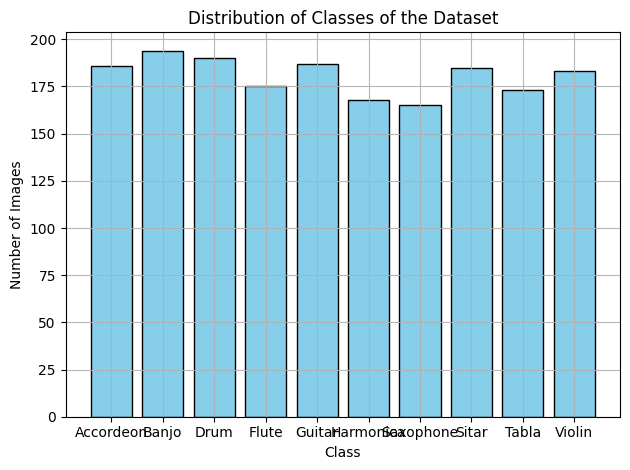

In [198]:
l_instruments = []
for _, instruments in full_dataset:
  l_instruments = np.append(l_instruments, np.argmax(instruments, axis=1).astype(int))

class_names = ["Accordeon", "Banjo", "Drum",
               "Flute", "Guitar", "Harmonica",
               "Saxophone", "Sitar", "Tabla",
               "Violin"]

# Crear histograma con 10 bins
num, bins, _ = plt.hist(
    l_instruments,
    bins=10,
    color="skyblue",
    stacked=False,
    edgecolor='black',
    rwidth=0.8
)

# Calculates the centers of each bar
x_pos = 0.5 * (bins[:-1] + bins[1:])  # 10 centered positions

# Plot configs
plt.grid(linestyle='-', alpha=0.9)
plt.title('Distribution of Classes of the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Place the labels on the X axis
plt.xticks(ticks=x_pos, labels=class_names, rotation=-0)

plt.tight_layout()
plt.show()

As seen, all the classes have roughly the same number of images, therefore it is not necessary to use a stratified approach and we can use the Accuracy scoring as a performance metric.

EfficientNet B3

In [36]:
# Define the input image shape
img_shape = (196, 196, 3)  # 196x196 RGB images

# Load EfficientNetB3 as the base model without the top classification layer
base_model = EfficientNetB3(
    weights='imagenet',  # Use pretrained weights from ImageNet
    input_shape=img_shape, # Input shape must match our image dimensions
    include_top=False,  # Exclude the final dense layers from EfficientNet
    classes=10 # This is ignored when include_top=False
)

# Define a data augmentation pipeline to help improve model generalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images
    tf.keras.layers.RandomRotation(0.4),  # Applied random rotations
    tf.keras.layers.RandomZoom(0.4),  # Random zoom-in and zoom-out
    tf.keras.layers.RandomContrast(0.2)# Adjusted image contrast
])

# Define the full model architecture
inputs = tf.keras.layers.Input(shape=img_shape) # Input layer for the model
x = data_augmentation(inputs)  # Applied data augmentation
x = base_model(x, training=False) # Passes through EfficientNet base

# Apply global average pooling to reduce spatial dimensions
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add fully connected layers with batch normalization and dropout for regularization
x = tf.keras.layers.Dense(3096, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)

# Final output layer with softmax activation for multi-class classification
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create the model
Ef_3 = tf.keras.models.Model(inputs=inputs, outputs=x)

# Print a summary of the model architecture
Ef_3.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 196, 196, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 196, 196, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3096)           │     4,758,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3096)           │        12,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 3096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │     1,585,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,209,137 (65.65 MB)

 Trainable params: 17,114,618 (65.29 MB)

 Non-trainable params: 94,519 (369.22 KB)

Selection of Base Models Compilation Parameters

In [37]:
# Model compilation adding the optimizer, loss for multi-class labels and metrics as accuracy.
Ef_3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# The training will stop when the validation loss has not achieved a significant change in loss.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# The following is a function that reduces the learning rate when there is no significant change in
# validation loss. This decreases in steps of 0.1 when after 3 epochs the loss has not changed.

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-7
)

Training of the Base Model 3 (Efficient Net B3)

In [38]:
history = Ef_3.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr, StopOnValAccuracy(target=0.950)]
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 495ms/step - accuracy: 0.3409 - loss: 2.2685 - val_accuracy: 0.5574 - val_loss: 1.7775 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 359ms/step - accuracy: 0.6102 - loss: 1.2715 - val_accuracy: 0.7240 - val_loss: 0.9895 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.6623 - loss: 1.1303 - val_accuracy: 0.7760 - val_loss: 0.8735 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 358ms/step - accuracy: 0.7164 - loss: 1.0467 - val_accuracy: 0.7568 - val_loss: 0.9487 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 351ms/step - accuracy: 0.7463 - loss: 0.8788 - val_accuracy: 0.7842 - val_loss: 0.9971 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step - accuracy: 0.7633 - loss: 0.8361 - val_accuracy: 0.7377 - val_loss: 0.9296 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 365ms/step - accuracy: 0.7967 - 

EfficientNet B2

In [39]:
base_model = EfficientNetB2( # Again, the base model #2 is selected, designed and summarized.
    weights="imagenet",
    input_shape=img_shape,
    include_top=False,
    classes=10
)

inputs = tf.keras.layers.Input(shape=img_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3096, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

Ef_2 = tf.keras.models.Model(inputs=inputs, outputs=x)

Ef_2.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 196, 196, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 196, 196, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 7, 7, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3096)           │     4,362,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 3096)           │        12,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │     1,585,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,864,827 (52.89 MB)

 Trainable params: 13,790,036 (52.60 MB)

 Non-trainable params: 74,791 (292.16 KB)

Base Model #2 Compilation

In [40]:
# As did in the Base Model #3, the same parameters and streamline is followed.
Ef_2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = Ef_2.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr, StopOnValAccuracy(target=0.950)]
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 384ms/step - accuracy: 0.3898 - loss: 2.0471 - val_accuracy: 0.5956 - val_loss: 1.3524 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step - accuracy: 0.6424 - loss: 1.3551 - val_accuracy: 0.7650 - val_loss: 0.7585 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 294ms/step - accuracy: 0.7179 - loss: 0.9769 - val_accuracy: 0.6831 - val_loss: 1.2368 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - accuracy: 0.7153 - loss: 0.9925 - val_accuracy: 0.7404 - val_loss: 0.9402 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 282ms/step - accuracy: 0.7132 - loss: 0.9079 - val_accuracy: 0.7268 - val_loss: 0.9574 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 285ms/step - accuracy: 0.7658 - loss: 0.7971 - val_accuracy: 0.8224 - val_loss: 0.5898 - learning_rate: 1.0000e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - accuracy: 0.8190

EfficientNetB1

In [41]:
base_model = EfficientNetB1( # Base Model #1 is defined, designed and summarized,
    weights="imagenet",
    input_shape=img_shape,
    include_top=False,
    classes=10
)

inputs = tf.keras.layers.Input(shape=img_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(3096, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

Ef_1 = tf.keras.models.Model(inputs=inputs, outputs=x)

Ef_1.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 196, 196, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 196, 196, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb1 (Functional)     │ (None, 7, 7, 1280)     │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3096)           │     3,965,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 3096)           │        12,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 3096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │     1,585,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,275,209 (46.83 MB)

 Trainable params: 12,205,938 (46.56 MB)

 Non-trainable params: 69,271 (270.59 KB)

In [42]:
# Using the same fitting and compilation parameters, the model #1 is trained.
Ef_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = Ef_1.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr, StopOnValAccuracy(target=0.950)]
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 77s 383ms/step - accuracy: 0.3657 - loss: 2.1359 - val_accuracy: 0.5984 - val_loss: 1.2723 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - accuracy: 0.6411 - loss: 1.1530 - val_accuracy: 0.6093 - val_loss: 1.7425 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - accuracy: 0.6959 - loss: 1.1115 - val_accuracy: 0.6230 - val_loss: 2.2267 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 273ms/step - accuracy: 0.6772 - loss: 1.0278 - val_accuracy: 0.6639 - val_loss: 1.1090 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.7363 - loss: 0.9037 - val_accuracy: 0.6612 - val_loss: 1.8751 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - accuracy: 0.6865 - loss: 1.0537 - val_accuracy: 0.7350 - val_loss: 1.1281 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - accuracy: 0.7149 - l

Predictions

### Meta Model Training

Here, the dataset that will be used for the training of the Meta Model is not going to be created. For this, the data used is the Meta Data which holds 40% of the images given.

In [10]:
pbase_meta, lbase_meta = base_predict(Ef_1, Ef_2, Ef_3, meta_dataset) # The models trained are
# the input parameters as well as the meta dataset splitted previously.

The following line of code performs the Nested Cross Validation and the Cross Validation for obtaining the best model. Here the idea is that, once the predictions of the base models were obtained the next step is to train and evaluate the performance of the model over this dataset and acquire the best set of parameters that can outperform or ensure a high performance.
For this case, the META model selected is CatBoost.

In [16]:
# Meta Model is called and defined.
ct_boost = CatBoostClassifier(loss_function='MultiClass',
                           verbose=False)
# Grid of parameters of the meta model.
param_grid = {
    'iterations': [100, 300],
    'depth': [4, 6, 9],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 6],
}

# Inner folds of the set are modelled using 5 splits and mixing all them up.
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# The method of Grid Search is modelled.
grid_search = GridSearchCV(estimator=ct_boost,
                           param_grid=param_grid,
                           cv=inner_cv,
                           scoring='accuracy',
                           n_jobs=-1)

# The outer folds are declared.
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# The Nested Cross Validation is defined and performed.
nested_scores = cross_val_score(grid_search, pbase_meta, lbase_meta, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print(f"Nested CV mean accuracy: {np.mean(nested_scores):.4f}") # List of accuracies across all folds are printed.
print(f"All outer scores: {nested_scores}") # Mean of scores.

Nested CV mean accuracy: 0.9083
All outer scores: [0.89583333 0.9375     0.93055556 0.86805556 0.90972222]


Now, once the expected score across different folds of the dataset is finally obtained, the next step is to train the META model and lastly, obtain the best model fitted.

In [19]:
grid_search.fit(pbase_meta, lbase_meta) # Model is fitted using the Meta training dataset.
ct_best = grid_search.best_estimator_ # The best model fitted is returned and saved.

The following tests the best model out employing the test dataset, same used for testing the Base Models.

In [61]:
pbase_test, lbase_test = base_predict(Ef_1, Ef_2, Ef_3, test_dataset) # The predictions for the test dataset are obtained along with their labels.
print(f"The Accuracy score for the Full Model (BASE & META Models) is: {round(accuracy_score(ct_best.predict(pbase_test), lbase_test), 2)*100} %") # Accuracy is pritned.

The Accuracy score for the Full Model (BASE & META Models) is: 89.0 %


Once the predictions were acquired using the test set by now including BASE -> META Models, the next step is to evaluate the model by F1 Score, Recall and Precision.

In [62]:
final_preds = ct_best.predict(pbase_test) # Predictions of the Full System.

report = classification_report( # Report of performance declared.
    lbase_test,
    final_preds,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0     0.9355    0.9667    0.9508        30
           1     0.9143    0.8889    0.9014        36
           2     1.0000    0.9524    0.9756        42
           3     0.7500    0.8710    0.8060        31
           4     0.8409    0.8810    0.8605        42
           5     0.9118    0.9394    0.9254        33
           6     0.9310    0.8182    0.8710        33
           7     0.9118    0.7750    0.8378        40
           8     0.8000    0.9231    0.8571        39
           9     0.9737    0.9250    0.9487        40

    accuracy                         0.8934       366
   macro avg     0.8969    0.8941    0.8934       366
weighted avg     0.8988    0.8934    0.8941       366



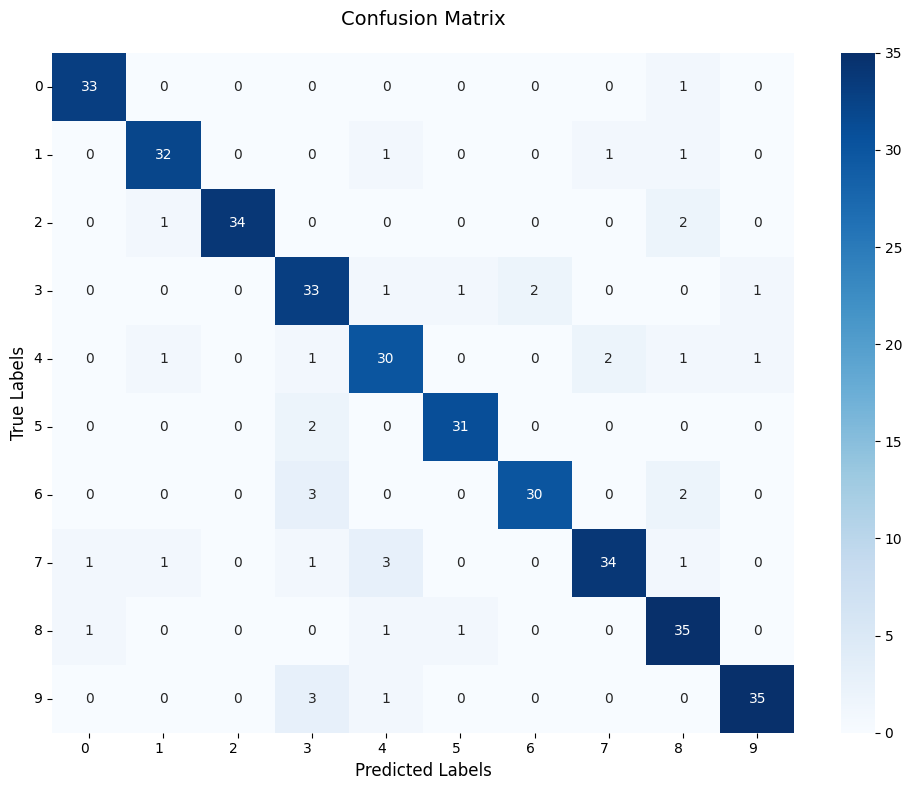

In [27]:
plot_confusion_matrix(lbase_test, final_preds) # Confusion Matrix is printed.

Image and prediction is plotted

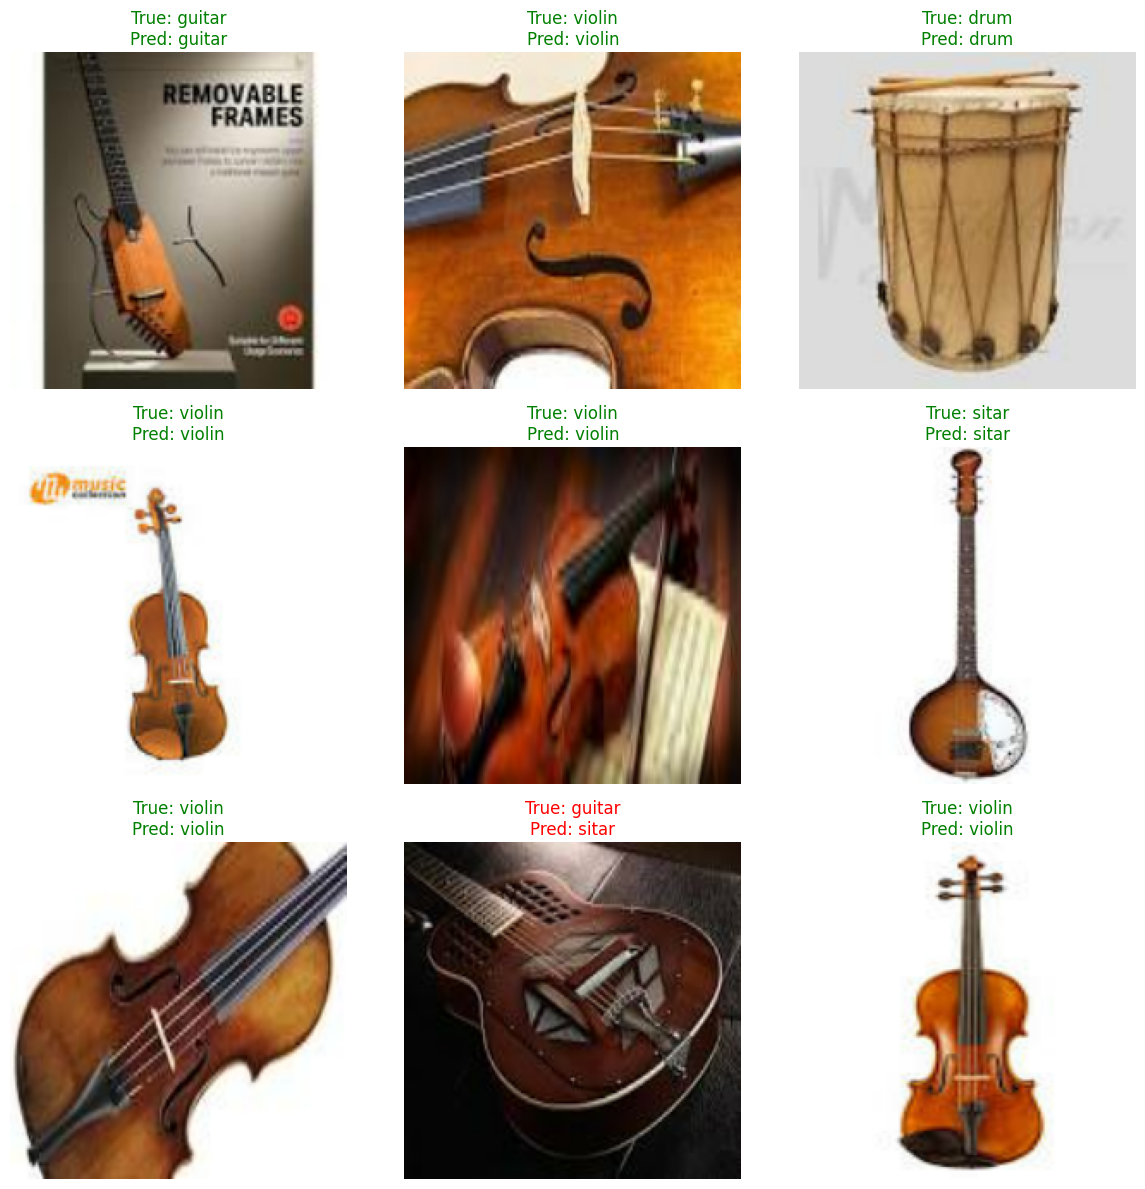

In [120]:
plot_predictions(dataset=test_dataset, class_names=class_names) # The Function is called.

As seen the model struggles to differentiate between a Sitar and a Guitar, but, on the other hand, the rest of the predictions are completely accurate and are aligned with the expected performance of the full system (Base and Meta Models).